In [1]:
import torch
import torchvision

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/content/drive/My Drive/HIP2019/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1.0,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/content/drive/My Drive/HIP2019/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1.0,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


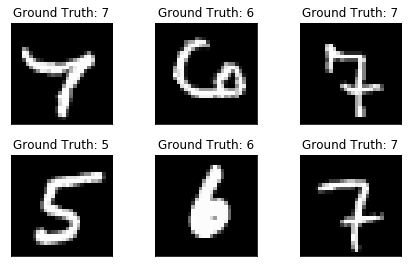

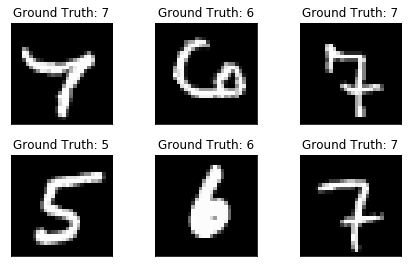

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [0]:
from torch.autograd import Variable
import numpy as np

# parameters of neural net
r = 1.0
W1 = Variable(torch.torch.FloatTensor(28*28, 100).uniform_(-r,r)/np.sqrt(28*28), requires_grad=False)
b1 = Variable(torch.zeros((1,100)), requires_grad=False)                            
W2 = Variable(torch.torch.FloatTensor(100, 20).uniform_(-r,r)/np.sqrt(100), requires_grad=False)
b2 = Variable(torch.zeros([1,20]), requires_grad=False)                             
W3 = Variable(torch.torch.FloatTensor(20, 10).uniform_(-r,r)/np.sqrt(20), requires_grad=False)
b3 = Variable(torch.zeros([1,10]), requires_grad=False)                               

eps=1e-20

n_epochs = 2
log_interval = 100
learning_rate = 1e-5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

# test
test_loss = 0
correct = 0
for data, target in test_loader:
  # forward pass
  X = data.view(data.size(0), -1)
  Z1 = F.relu(torch.mm(X,W1)+b1)
  Z2 = F.relu(torch.mm(Z1,W2)+b2)
  Z3 = torch.mm(Z2,W3)+b3
  output = F.softmax(Z3,dim=1)

  test_loss += -torch.sum(torch.log(output[:,target]+eps))
  pred = output.data.max(1, keepdim=True)[1]
  correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


for epoch in range(1, n_epochs + 1):    
  # training
  for batch_idx, (data, target) in enumerate(train_loader):
    # forward pass
    X = data.view(data.size(0), -1)
    Z1 = F.relu(torch.mm(X,W1)+b1)
    Z2 = F.relu(torch.mm(Z1,W2)+b2)
    Z3 = torch.mm(Z2,W3)+b3
    Yp = F.softmax(Z3,dim=1)
    
    loss = -torch.mean(torch.log(Yp[:,target]+eps))
    
    #backward pass
    dZ3 = Yp
    dZ3[:,target] += -1.0 # note that this changes Yp too, need to undo at an appropriate place
    dZ2 = torch.mm(dZ3,torch.transpose(W3,0,1))
    dZ1 = torch.mm(Z2.sign()*dZ2,torch.transpose(W2,0,1))
    
    dW3 = torch.mm(torch.transpose(Z2,0,1),dZ3) / data.size(0)
    dW2 = torch.mm(torch.transpose(Z1,0,1),Z2.sign()*dZ2) / data.size(0)
    dW1 = torch.mm(torch.transpose(X,0,1),Z1.sign()*dZ1) / data.size(0)

    db3 = torch.sum(dZ3,0,True) / data.size(0)
    db2 = torch.sum(Z2.sign()*dZ2,0,True) / data.size(0)
    db1 = torch.sum(Z1.sign()*dZ1,0,True) / data.size(0)
        
    W1 = W1 - learning_rate*dW1
    W2 = W2 - learning_rate*dW2
    W3 = W3 - learning_rate*dW3
    b1 = b1 - learning_rate*db1
    b2 = b2 - learning_rate*db2
    b3 = b3 - learning_rate*db3

    if batch_idx % log_interval == 0:
      Yp[:,target] = Yp[:,target] + 1.0 # undoing changes in Yp
      loss = -torch.mean(torch.log(Yp[:,target]+eps))
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/content/drive/My Drive/HIP2019/MNIST_NN_results/model.pth')
      #torch.save(optimizer.state_dict(), '/content/drive/My Drive/HIP2019/MNIST_NN_results/optimizer.pth')
      
  # test
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    # forward pass
    X = data.view(data.size(0), -1)
    Z1 = F.relu(torch.mm(X,W1)+b1)
    Z2 = F.relu(torch.mm(Z1,W2)+b2)
    Z3 = torch.mm(Z2,W3)+b3
    output = F.softmax(Z3,dim=1)

    test_loss += -torch.sum(torch.log(output[:,target]+eps))
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  
print(W1)


Test set: Avg. loss: 230.3109, Accuracy: 619/10000 (6%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301717
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.304808
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.304179
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.303120
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.305518
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.308371
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.304523
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.303658
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.305803
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.303061

Test set: Avg. loss: 2302.9834, Accuracy: 627/10000 (6%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.303736
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.304628
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.301383
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.301124
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.303759
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.303512
